In [11]:
from data_gen import generate_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [12]:
def extract_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Extract useful information from a given CloudFront DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame to extract information from. It should have columns 'date', 'time',
        'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.

    Returns:
        pd.DataFrame: A new DataFrame containing only the useful information extracted from the input DataFrame. The
        new DataFrame has columns 'datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.
    """
    # merge date and time columns
    dataframe['datetime'] = pd.to_datetime(dataframe['date'] + ' ' + dataframe['time'])

    # drop the original date and time columns
    temp_df = dataframe.drop(['date', 'time'], axis=1, errors='ignore')

    # set datetime column as first column
    temp_df.insert(0, 'datetime', temp_df.pop('datetime'))

    # Extract useful information from df
    df = dataframe.loc[:, ['datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', 'cs_uri_stem']]

    return df

In [13]:
def find_unique_addresses(dataframe: pd.DataFrame) -> np.ndarray:
    """
    Returns an array of unique IP addresses from the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the CloudFront access log data.

    Returns:
    np.ndarray: An array of unique IP addresses found in the 'c_ip' column of the DataFrame.
    """
    unique_ips = dataframe['c_ip'].unique()
    return unique_ips

def count_visits_per_ip(dataframe: pd.DataFrame, ip_address: str = None) -> pd.core.series.Series:
    """ 
    Returns the number of visits per IP address in the given DataFrame.
    If an IP address is specified, returns the number of visits for that IP only.
    """
    if ip_address:
        unique_ips = find_unique_addresses(dataframe)
        if ip_address in unique_ips:
            return dataframe['c_ip'].value_counts()[ip_address]
        else:
            return 0
    else:
        ip_counts = dataframe['c_ip'].value_counts()
        return ip_counts


In [14]:
def show_edge_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Displays a pie chart of the traffic distribution between the top N edge locations in the given DataFrame.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the CloudFront access log data.
    top_n : int, optional
        The number of top edge locations to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    if top_n > 20:
        top_n = 20
    edge_location_counts = dataframe['x_edge_location'].value_counts()

    # Create a pie chart of the location counts
    plt.pie(edge_location_counts.head(top_n), labels=edge_location_counts.head(top_n).index, autopct='%1.1f%%')
    plt.title('Traffic between top {} edge locations'.format(top_n))
    plt.axis('equal')

In [46]:
import json
import urllib.request

def get_location(ip: str) -> str:
  """
  Retrieve the country associated with an IP address.

    Parameters:
    ip (str): The IP address to lookup.

    Returns:
    str: The country associated with the IP address, or 'Unknown' if no country information is available.
  """
  response = urllib.request.urlopen('http://ipwho.is/'+ip)
  ipwhois = json.load(response)

  if 'country' in ipwhois:
    return ipwhois['country']
  else:
    return 'Unknown'

def plot_country_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Plots a pie chart showing the distribution of traffic by country based on the given DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        A pandas DataFrame containing CloudFront access log data.
    top_n : int, optional
        The number of top countries to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    if top_n > 20:
        top_n = 20
    
    # Find location for each c_ip in the DataFrame
    dataframe['location'] = dataframe['c_ip'].apply(get_location)
    location_counts = dataframe['location'].value_counts().head(top_n)

    # Create a pie chart of the location counts
    plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%')
    plt.title('Traffic between top {} countries'.format(top_n))
    plt.axis('equal')
    plt.show()

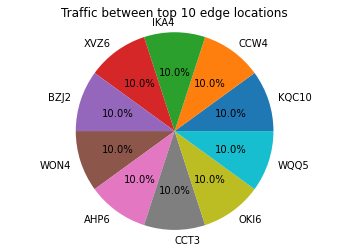

In [51]:
# 1.
full_df = generate_data(100)
df = extract_data(full_df)

# 2.
unique_ips = find_unique_addresses(df)

# 3.
count_visits_per_ip(df)

# 4.
show_edge_traffic(df)

# 5.
plot_country_traffic(df)